# Quantify the difference in Complexity Penalty between Unconstrained and OAK in 2D

In [2]:
%run imports.py

seed = 4
np.random.seed(seed)
tf.random.set_seed(seed)

All packages loaded successfully.


In [3]:
# --- Generate synthetic 2D data ---
def true_function(X):
    x1, x2 = X[:,0], X[:,1]
    return np.sin(x1*2) + 3*x2**3 + x1*np.sin(x2*2)

n = 1000
noise = 0.01
X = np.random.normal(0, 1, size=(n,2))
y = true_function(X) + np.random.normal(0, noise, size=n)
y = y.reshape(-1, 1)
y_mean, y_std = np.mean(y), np.std(y)
y = (y - y_mean) / y_std

In [4]:
# --- Create OAK model ---
data = (X, y)
oak = create_model_oak(
    data=data,
    max_interaction_depth=2,
    constrain_orthogonal=True,
    share_var_across_orders=True,
    use_sparsity_prior=False,
)

# --- Train model ---
opt = gpflow.optimizers.Scipy()
opt.minimize(oak.training_loss, oak.trainable_variables, options=dict(maxiter=1000, gtol=1e-8, ftol=1e-12, disp=True))

# --- Print model summary ---
gpflow.utilities.print_summary(oak)
print(f"Training NLL is {oak.training_loss()}")

K_oak = oak.kernel.K(X, X) + tf.eye(n, dtype=tf.float64) * oak.likelihood.variance.numpy()
alpha_oak = tf.linalg.solve(K_oak, tf.convert_to_tensor(y, dtype=tf.float64))
oak_datafit = 0.5 * y.T@alpha_oak
L = tf.linalg.cholesky(K_oak)
oak_complexity = tf.reduce_sum(tf.math.log(tf.linalg.diag_part(L))).numpy()

╒════════════════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤══════════════╕
│ name                                           │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │        value │
╞════════════════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪══════════════╡
│ GPR.kernel.kernels[0].base_kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │   2.50751    │
├────────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────────┤
│ GPR.kernel.kernels[1].base_kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │   1.56222    │
├────────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────────┤
│ GPR.kernel.

In [5]:
# --- Create AGP model ---
data = (X, y)
model = create_model_oak(
        data=data,
        max_interaction_depth=2,
        constrain_orthogonal=False,
        share_var_across_orders=True,
        use_sparsity_prior=False,
)

# --- Train model ---
opt = gpflow.optimizers.Scipy()
opt.minimize(model.training_loss, model.trainable_variables, options=dict(maxiter=1000, gtol=1e-8, ftol=1e-12, disp=True))

# --- Print model summary ---
gpflow.utilities.print_summary(model)
print(f"Training NLL is {model.training_loss()}")

K_model = model.kernel.K(X, X) + tf.eye(n, dtype=tf.float64) * model.likelihood.variance.numpy()
alpha_model = tf.linalg.solve(K_model, tf.convert_to_tensor(y, dtype=tf.float64))
model_datafit = 0.5 * y.T@alpha_model
L_model = tf.linalg.cholesky(K_model)
model_complexity = tf.reduce_sum(tf.math.log(tf.linalg.diag_part(L_model))).numpy()

╒════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤════════════╕
│ name                               │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │      value │
╞════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪════════════╡
│ GPR.kernel.kernels[0].lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │   2.49306  │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────┤
│ GPR.kernel.kernels[1].lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │   1.54193  │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────┤
│ GPR.kernel.variances[0]            │ Parameter │ Softplus         │         │ True        │ ()      │ float64

In [6]:
# --- Verify the posteriors and data fit terms are identical ---
x1_plot = np.linspace(-3, 3, 100)
x2_plot = np.linspace(-3, 3, 100)
X1_grid, X2_grid = np.meshgrid(x1_plot, x2_plot)
X_grid = np.stack([X1_grid.ravel(), X2_grid.ravel()], axis=1)

y_model, _ = model.predict_f(X_grid)
y_oak, _ = oak.predict_f(X_grid)

print(f"MSE is {mean_squared_error(y_model, y_oak)}")

MSE is 1.0699238845586823e-06


In [7]:
print(oak_datafit.numpy()[0][0], model_datafit.numpy()[0][0])
print()
print(oak_complexity, model_complexity)

308.4419369133982 308.5444351932488

-6632.971087366897 -6623.907244755208


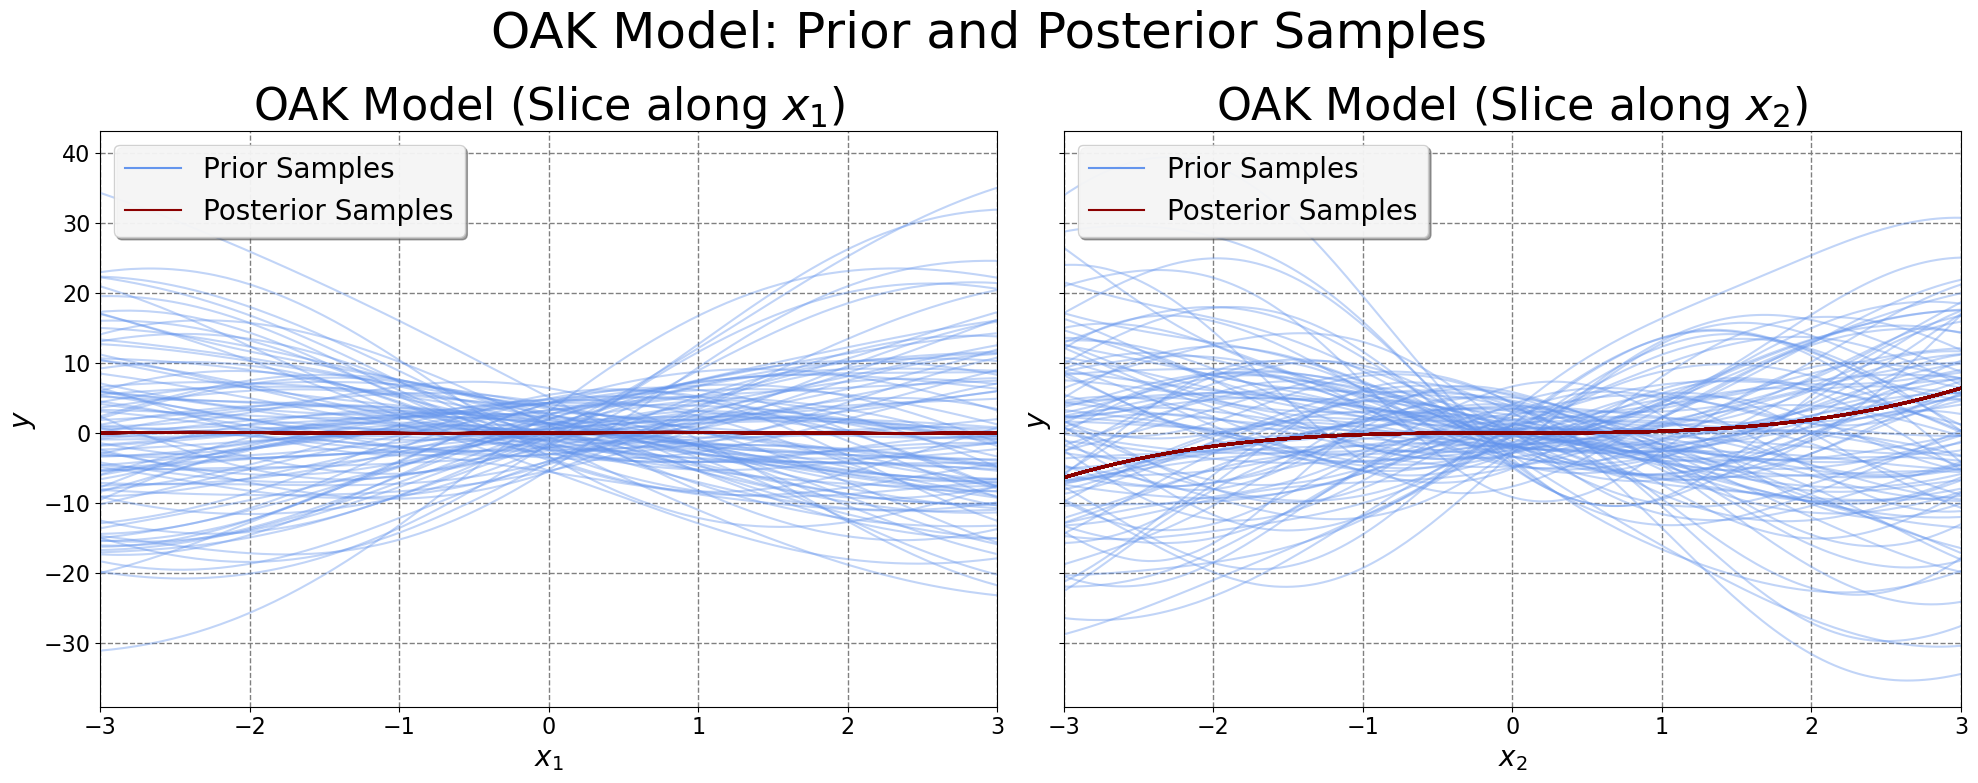

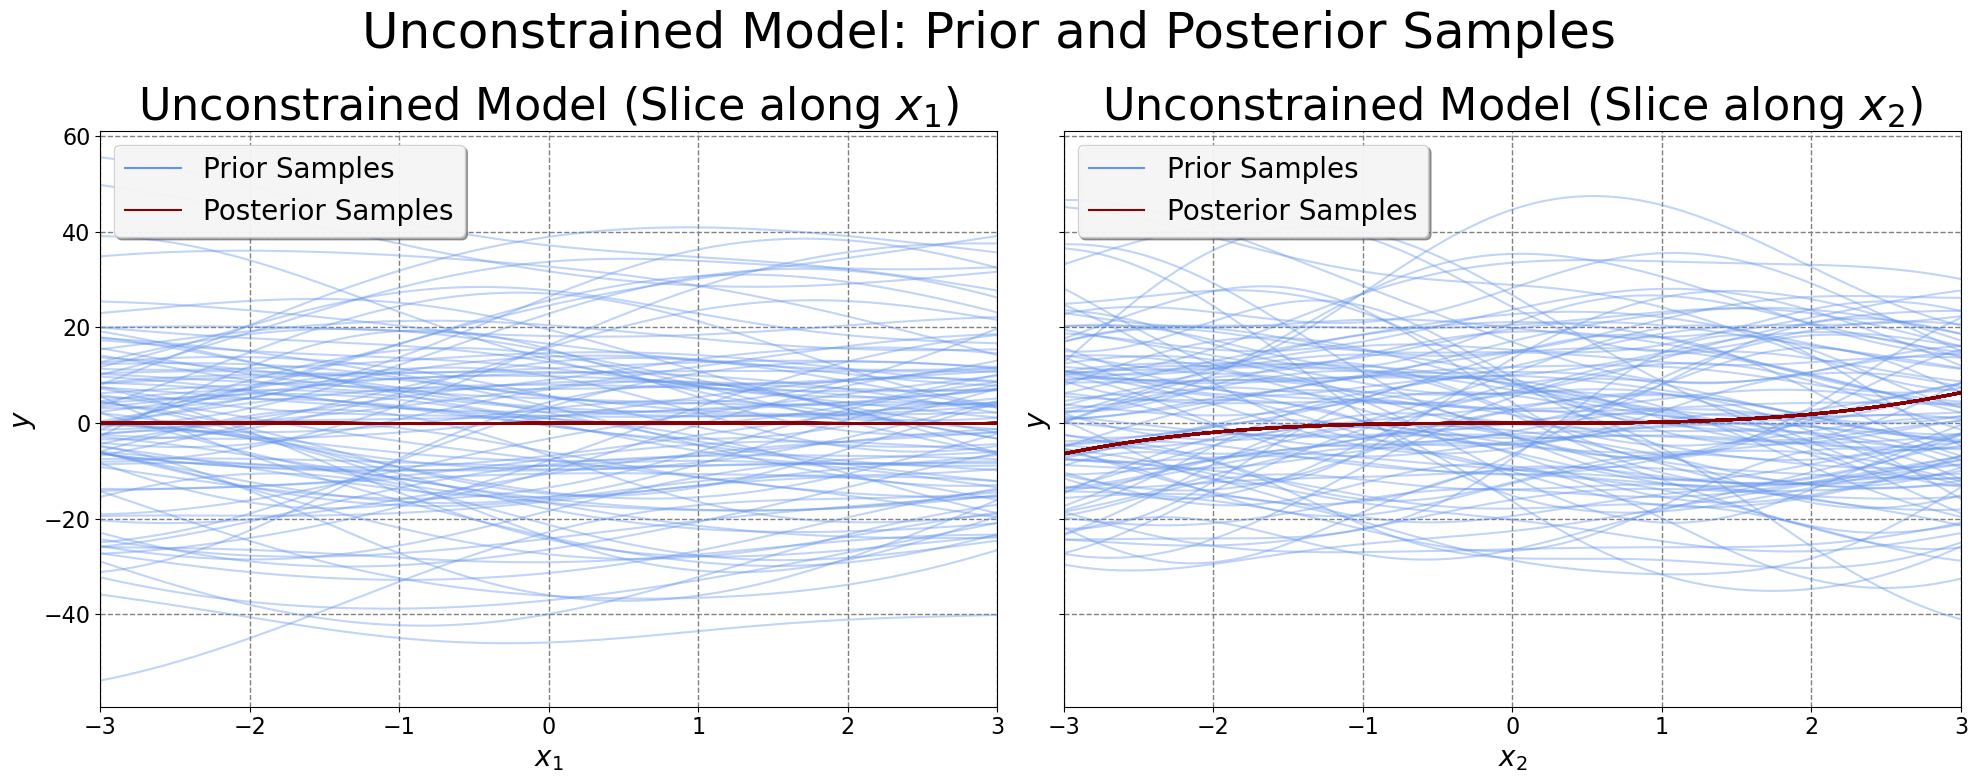

In [8]:
# --- Visualise the difference in function draws from the priors ---
num_samples = 100
num_test_points = 150
plot_range = (-3, 3)

x1_test = np.linspace(plot_range[0], plot_range[1], num_test_points)
x2_test = np.linspace(plot_range[0], plot_range[1], num_test_points)

X_test_slice1 = np.zeros((num_test_points, 2))
X_test_slice1[:, 0] = x1_test

X_test_slice2 = np.zeros((num_test_points, 2))
X_test_slice2[:, 1] = x2_test



def plot_prior_vs_posterior(ax, model_to_plot, X_test_slice, title, label):

    kernel = model_to_plot.kernel
    K = kernel(X_test_slice)

    jitter = 1e-6
    K += jitter * np.eye(num_test_points)
    
    mean_vector = np.zeros(num_test_points)
    prior_samples = np.random.multivariate_normal(mean_vector, K, size=num_samples)
    posterior_samples = model_to_plot.predict_f_samples(X_test_slice, num_samples)[:,:,0]

    for i in range(num_samples):
        ax.plot(X_test_slice[:, 0] if X_test_slice[0,1]==0 else X_test_slice[:, 1], prior_samples[i, :], '-', color='cornflowerblue', lw=1.5, alpha=0.4)
    for i in range(num_samples):
        ax.plot(X_test_slice[:, 0] if X_test_slice[0,1]==0 else X_test_slice[:, 1], posterior_samples[i, :], '-', color='darkred', lw=2, alpha=0.5)

    ax.plot([], [], '-', color='cornflowerblue', label='Prior Samples')
    ax.plot([], [], '-', color='darkred', label='Posterior Samples')
    
    ax.set_title(title)
    ax.set_xlabel(label)
    ax.set_ylabel('$y$')
    ax.legend(loc='upper left', frameon=True, shadow=True, fancybox=True, framealpha=0.9)
    ax.set_xlim([-3,3])
    ax.grid(True)

b = 60
# --- Figure 1: OAK Model ---
fig_oak, axes_oak = plt.subplots(1, 2, figsize=(20, 8), sharey=True)
plot_prior_vs_posterior(axes_oak[0], oak, X_test_slice1, 'OAK Model (Slice along $x_1$)', '$x_1$')
plot_prior_vs_posterior(axes_oak[1], oak, X_test_slice2, 'OAK Model (Slice along $x_2$)', '$x_2$')
fig_oak.suptitle('OAK Model: Prior and Posterior Samples', fontsize=36)
plt.tight_layout()
plt.show()


# --- Figure 2: Unconstrained Model ---
fig_agp, axes_agp = plt.subplots(1, 2, figsize=(20, 8), sharey=True)
plot_prior_vs_posterior(axes_agp[0], model, X_test_slice1, 'Unconstrained Model (Slice along $x_1$)', '$x_1$')
plot_prior_vs_posterior(axes_agp[1], model, X_test_slice2, 'Unconstrained Model (Slice along $x_2$)', '$x_2$')
fig_agp.suptitle('Unconstrained Model: Prior and Posterior Samples', fontsize=36)
plt.tight_layout()
plt.show()